In [75]:
import torch
import os
import pickle
import sys
import torch.nn.init as init
import dgl
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [76]:
key=True

In [77]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [78]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes1(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes2(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [79]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= 3) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [80]:
checkFile = os.path.isfile("data/dump/speaker_encoder.pkl")
encoded_speaker_list = []
ranges = []

if not checkFile:
    print("Run first the prototype_context_encoder to generate this file")
else:
    with open('data/dump/speaker_encoder.pkl', "rb") as file:
        encoded_speaker_list, ranges = pickle.load(file)

checkFile = os.path.isfile("data/dump/all_adjacency_list.pkl")
adjacency_list = []

if not checkFile:
    adjacency_list = get_all_adjacency_list(ranges)
else:
    with open('data/dump/all_adjacency_list', "rb") as file:
        adjacency_list = pickle.load(file)


In [81]:
file_path = 'embed/updated_representation.pkl'

# Load the list from the file using pickle
with open(file_path, 'rb') as file:
    updated_representations = pickle.load(file)

In [82]:
edge_indices = get_all_adjacency_list(ranges)
edge_types = get_all_edge_type_list(edge_indices, encoded_speaker_list)
edge_indices = get_all_adjacency_list(ranges, key=1)

<h4>Instantiating the GAT (first implementation)

In [83]:
num_in_features = 300
num_out_features = 300
num_heads = 4
num_edge_types = 3
gat_layer = GATLayerWithEdgeType(num_in_features, num_out_features, num_heads, num_edge_types)

In [84]:
i = 0  # dialogue id
h_prime, attention_coef = gat_layer((updated_representations[i], edge_indices[i]), edge_types[i])
print("h_prime shape: ", h_prime.shape, "attention_coef shape: ", attention_coef.shape)

target_nodes = edge_indices[i][1].tolist()

sample = {}
sample_edgetypes = []

for target_i in set(target_nodes):
    sample[target_i] = []

for target_node, idx in zip(target_nodes, range(len(target_nodes))):
    sample[target_node].append([idx, h_prime[target_node][idx].tolist()])

list_edge_idx, inferred_edgetypes = get_inferred_edgetypes1(sample, edge_types[i])
sample_edgetypes.append(inferred_edgetypes)


h_prime shape:  torch.Size([14, 50]) attention_coef shape:  torch.Size([14, 300, 50])


<h4>Exploratory Data Analysis

In [85]:
file = open('data/dump/label_decoder.pkl', 'rb')
label_decoder = pickle.load(file)
file.close()

label_decoder = list(label_decoder.values())
print(label_decoder)

['anger', 'fear', 'neutral', 'sadness', 'surprise', 'joy', 'disgust']


In [86]:
checkFile = os.path.isfile("data/dump/train_labels.pkl")

if checkFile is False:
    print("Please run the context_encoder notebook to save the label file")
else:
    file = open('data/dump/train_labels.pkl', 'rb')
    y_train = pickle.load(file)
    file.close()


<h5>Unsupervised Visualizarion
    
<h6> Visualize 1 instance then scale up

In [87]:
# Assuming h_prime contains the node embeddings
utt_size = 13
labels = torch.tensor(y_train[:utt_size + 1])

cherrypicked_nodes = []
for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
    cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())
cherrypicked_nodes = torch.tensor(cherrypicked_nodes)


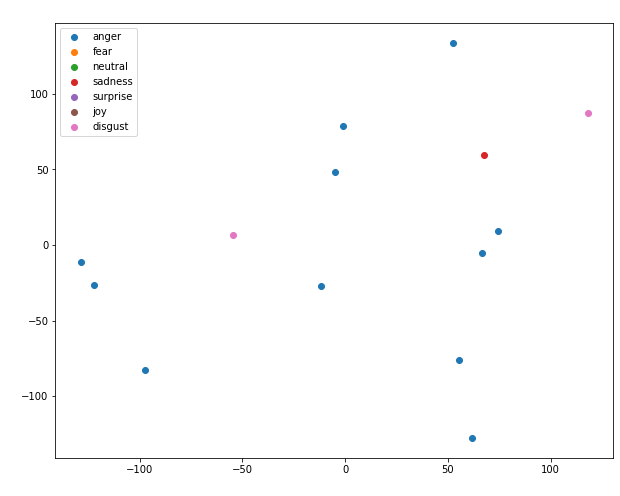

In [88]:
h_prime_np = cherrypicked_nodes.detach().numpy()

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
h_prime_tsne = tsne.fit_transform(h_prime_np)

# Plot the node embeddings with different colors for each label
plt.figure(figsize=(10, 8))
for label, emotion in zip(range(len(label_decoder)), label_decoder): 
    indices = (labels == label).nonzero().squeeze()
    plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
plt.title('Node Embeddings Visualization (t-SNE)', color="white")
plt.xlabel('Dimension 1', color="white")
plt.ylabel('Dimension 2', color="white")
plt.legend()
plt.show()

<h6>Now for all train data

In [89]:
## save the data in pickle format ##
checkFile = os.path.isfile("data/dump/1st_gat.pkl")

if key:
    print("Start of getting output of 1st GAT")
    all_inferred_edgetypes = []
    list_all_edge_idx = []
    cherrypicked_nodes = []
    for dialog, dialog_id in zip(updated_representations, range(len(updated_representations))):
        h_prime, attention_coef = gat_layer((dialog, edge_indices[dialog_id]), edge_types[dialog_id])
        target_nodes = edge_indices[dialog_id][1].tolist() # first idx represents dialogue id

        sample_edgetypes = {}
        for i in set(target_nodes):
            sample_edgetypes[i] = []

        for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
            sample_edgetypes[target_node].append([edge_idx, h_prime[target_node][edge_idx].tolist()])

        list_edge_idx, inferred_edgetypes = get_inferred_edgetypes1(sample_edgetypes,  edge_types[dialog_id])
        list_all_edge_idx.append(list_edge_idx)
        all_inferred_edgetypes.append(inferred_edgetypes)

        for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
            cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())

    cherrypicked_nodes = torch.tensor(cherrypicked_nodes)
    cherrypicked_nodes.shape
    print("End of getting output of 1st GAT")

    pickle.dump([cherrypicked_nodes, all_inferred_edgetypes],
                open('data/dump/1st_gat.pkl', 'wb'))
    
else:
    file = open('data/dump/1st_gat.pkl', 'rb')
    cherry_picked_nodes, all_inferred_edgetypes = pickle.load(file)
    file.close()

Start of getting output of 1st GAT
End of getting output of 1st GAT


In [90]:
# Convert tensor to numpy array
labels = torch.tensor(y_train)
h_prime_np = cherrypicked_nodes.detach().numpy()

In [91]:
runTSNE = 1

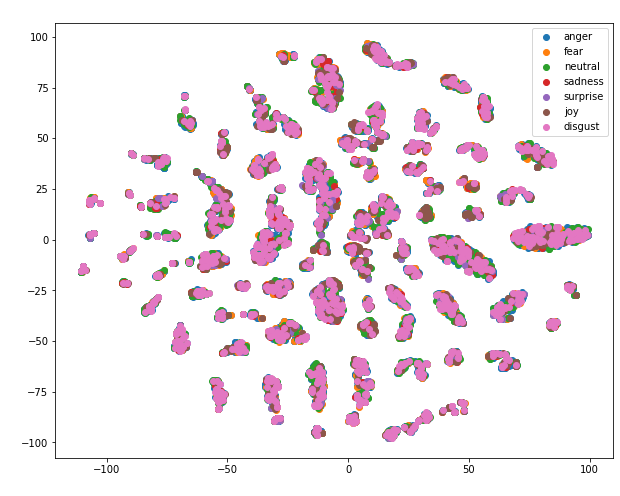

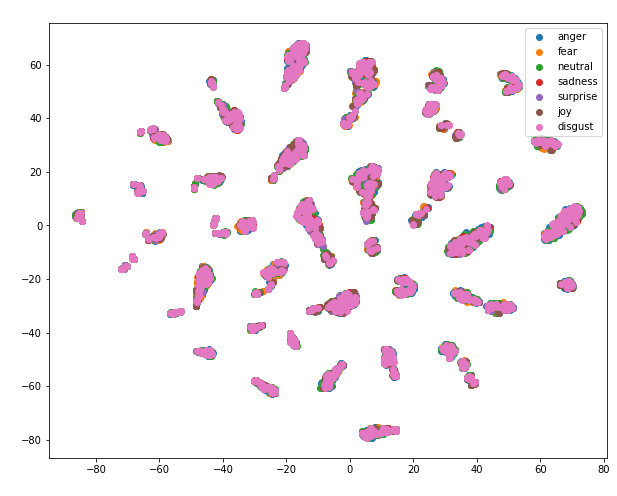

In [92]:
if runTSNE:
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)

        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()


Scale up 'till you get the edgetypes of all train dialogs 

In [93]:
# Assuming `all_inferred_edgetypes` and `y_train` are defined
df_eda = pd.DataFrame(
    {'edgetype': flatten_extend(all_inferred_edgetypes),
     'label': y_train,
    })

In [94]:
# Assuming `df_eda` and `CrosstabResult` are defined
CrosstabResult = pd.crosstab(index=df_eda['edgetype'], columns=df_eda['label'])

print("Crosstab Result:")
print(CrosstabResult)
print()

# Performing Chi-squared test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
# H0: The variables are not correlated with each other.

print('The P-Value of the Chi-Squared Test is:', ChiSqResult[1])

if ChiSqResult[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")

Crosstab Result:
label        0     1     2    3    4    5    6
edgetype                                      
0         2218   407   941   97  117  277  591
2         3742  1093  1371  241  247  599  899

The P-Value of the Chi-Squared Test is: 6.372109133776597e-20
Two variables are correlated


Below is a sample usage of GAT (second implementation)

In [95]:
egat = EGATConv(in_node_feats=300,
                    in_edge_feats=3,
                    out_node_feats=300,
                    out_edge_feats=3,
                    num_heads=4)

In [96]:
# Check if the pickle file exists
checkFile = os.path.isfile("data/dump/2nd_gat.pkl")

if key:
    print("Start of getting output of 2nd GAT")
    inferred_edgetypes2 = []
    all_node_feats = []
    
    # Iterate over each dialogue
    for dialog_id in range(len(updated_representations)):
        # Create a DGL graph
        graph = dgl.graph((edge_indices[dialog_id][0], edge_indices[dialog_id][1]))
        
        # Get one-hot encoded edge features
        edge_feats = get_ohe(edge_types[dialog_id])
        
        # Get outputs from the second GAT layer
        egat_output = egat(graph, updated_representations[dialog_id], edge_feats)
        new_node_feats, new_edge_feats = egat_output
        
        # Compute mean edge features
        mean_edge_feats = new_edge_feats.mean(dim=1)
        all_node_feats.append(new_node_feats.mean(dim=1).tolist())
        
        # Prepare edge features for inference
        target_nodes = edge_indices[dialog_id][1].tolist()
        sample_edgetypes = {}
        for i in set(target_nodes):
            sample_edgetypes[i] = []
        for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
            sample_edgetypes[target_node].append([edge_idx, mean_edge_feats[edge_idx].tolist()])
        
        # Infer edge types
        sample_edgetypes = get_inferred_edgetypes2(sample_edgetypes, edge_types[dialog_id], len(updated_representations[dialog_id]), dialog_id)
        inferred_edgetypes2.append(sample_edgetypes)
    
    # Flatten and convert node features to tensor
    all_node_feats = torch.tensor(flatten_extend(all_node_feats))
    
    print("End of getting output of 2nd GAT")
    
    # Save the data to a pickle file
    pickle.dump([all_node_feats, inferred_edgetypes2], open('data/dump/2nd_gat.pkl', 'wb'))
else:
    # Load data from the existing pickle file
    file = open('data/dump/2nd_gat.pkl', 'rb')
    all_node_feats, inferred_edgetypes2 = pickle.load(file)
    file.close()

Start of getting output of 2nd GAT
End of getting output of 2nd GAT


In [97]:
df_eda2 = pd.DataFrame(
    {'edgetype': flatten_extend(inferred_edgetypes2),
     'label': y_train,
    })

In [98]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a DataFrame from your data (df_eda2)
# Assuming df_eda2 is already defined

# Crosstabulation
CrosstabResult2 = pd.crosstab(index=df_eda2['edgetype'], columns=df_eda2['label'])
print("Crosstab Result:\n", CrosstabResult2)

# Performing Chi-squared test
ChiSqResult2 = chi2_contingency(CrosstabResult2)

# Print the p-value of the Chi-squared test
print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])

# Interpret the p-value
if ChiSqResult2[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")


Crosstab Result:
 label        0     1     2    3    4    5     6
edgetype                                       
0         4956  1295  1871  288  305  739  1226
2         1004   205   441   50   59  137   264
The P-Value of the ChiSq Test is: 0.0012723314350347537
Two variables are correlated


Testing on 1 dialog data before scaling up

In [99]:
dialog_id = 0

# Create a DGL graph
graph = dgl.graph((edge_indices[dialog_id][0], edge_indices[dialog_id][1]))

# Obtain one-hot encoded edge features
edge_feats = get_ohe(edge_types[dialog_id])

# Pass the graph, node representations, and edge features through the EGAT model
new_node_feats, new_edge_feats = egat(graph, updated_representations[dialog_id], edge_feats)

# Print the shapes of the new node and edge features
print("New Node Features Shape:", new_node_feats.shape)
print("New Edge Features Shape:", new_edge_feats.shape)

# Calculate the mean of node features along the second dimension (number of nodes)
h_prime_mean = new_node_feats.mean(dim=1)

# Assuming you want to select only a subset of labels for visualization
utt_size = 13
labels = torch.tensor(y_train[:utt_size+1])

New Node Features Shape: torch.Size([14, 4, 300])
New Edge Features Shape: torch.Size([50, 4, 3])


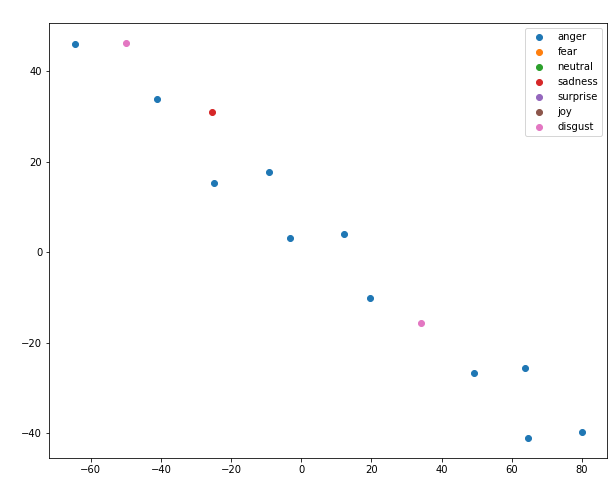

In [100]:
# Convert tensor to numpy array
h_prime_np = h_prime_mean.detach().numpy()
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
h_prime_tsne = tsne.fit_transform(h_prime_np)

# Plot the node embeddings with different colors for each label
plt.figure(figsize=(10, 8))
for label, emotion in zip(range(len(label_decoder)), label_decoder): 
    indices = (labels == label).nonzero().squeeze()
    plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
plt.title('Node Embeddings Visualization (t-SNE)', color="white")
plt.xlabel('Dimension 1', color="white")
plt.ylabel('Dimension 2', color="white")
plt.legend()
plt.show()


In [101]:
runTSNE = 1

(12840, 2)


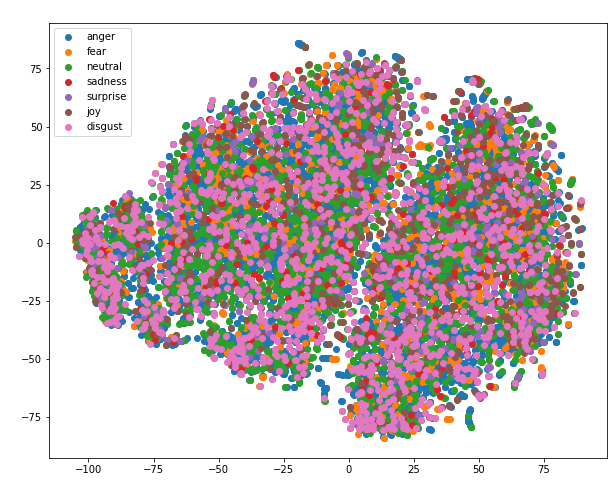

(12840, 2)


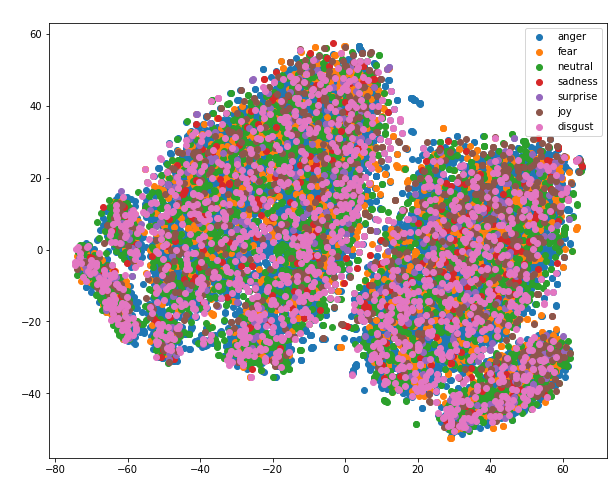

In [102]:
if runTSNE:
    # Convert tensor to numpy array
    h_prime_np = all_node_feats.detach().numpy()
    labels = torch.tensor(y_train)
    
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)
        print(h_prime_tsne.shape)
        
        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()
